In [1]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
import glob,os
warnings.filterwarnings('ignore')

In [2]:
counting_all_reporting_worse_alignment = False
allpenalty = ['bowtie','bwa','minimap','mapper']
pairing_bonus = 500 # bonus giving to paired-end alignment
speciesset = {
    'Bactor':['am_BaFr']#['af_BaCa','bf_BaFr','cx_BaTh','cx_BaXy','cx_BaSt']
}
palette_set = {
    'bowtie2':'#878787','minimap2':'#bababa','bwa':'#e0e0e0',
    'mapper':'#ca0020','mapper 16mer':'#fddbc7',
    'mapper 20mer':'#f4a582','mapper 24mer':'#d6604d',
        'bowtie2 all':'#2166ac','minimap2 all':'#67a9cf','bwa all':'#d1e5f0',
    'strobealign':'#000000',
    'last':'#252525',
    'strobealign all':'#053061',
     'mapper no gapped-xmer':'#f4a582',
    }

for penalty in allpenalty:
    folder = 'SNP_model_multi/%s/'%(penalty)
    toolset = [
        'mapper1.nogap',
    #     'mapper1', 
    # 'mapper1.kmer16','mapper1.kmer20','mapper1.kmer24',
    #     'strobealign.all','strobealign','last',
             # 'bowtie.all','minimap.all','bwa.all','bowtie','minimap','bwa', 
              ]#'mapper1.ancestor', 'mapper1.nogap',
    print('process',folder)
    for species in speciesset:
        genomeset = speciesset[species]
        print(species,genomeset)
        # process
        for tool in toolset:#toolset[:1]:#toolset[-1:]:
            score_tag = 'AS'
            if tool == 'mapper1':
                score_tag = 'CAS'
            allsam = ''
            allsam1 = ''
            subsammapper = ''
            samcomparemapper = ''
            alignmentsum = ''
            alignment_allworse = ''
            alignment_allbetter = ''
            alignment_allsame = ''
            alignmentsum = ''
            alignment_allworse_all_suboptimal = ''
            alignment_allworse_single_miss = ''
            alignment_allworse = ''
            
            allsam = pd.read_csv('%s/all_1.fastq_%s.%s.sam'%(folder,species,tool), 
                             sep='\t',usecols=[0, 1, 2,3,4,5],header=0, 
                             names=['readID', 'Direction','CHRmerge', 'POSmerge','Tagmerge','Scoremerge'],comment='@')
#             allsam = allsam[allsam['readID']=='af_BaCa_SL-NXA:H2H7HBGX3170812:H2H7HBGX3:1:12305:8912:19764']
##             allsam = allsam.sort_values(['readID','CHRmerge','POSmerge'])
            allsam['Tagmerge'] = [x.split(':')[0] for x in allsam['Tagmerge']]
            allsam=allsam.drop_duplicates(['readID','Direction', 'CHRmerge', 'POSmerge','Scoremerge'])
#             allsam['fastq']=['_'.join(x.split('_')[:2]) for x in allsam['readID']]
            allsam['newfastq']=['_'.join(x.split('_')[:2]) for x in allsam['CHRmerge']]
            allsam['Direction'] = [str(x&16>0) for x in allsam['Direction']]
            allsam['readIDnew'] = allsam['readID']+ ':D' +allsam['Direction']
            allsam['readIDCHRPOS']=allsam['readID']+ allsam['CHRmerge'] + [str(x) for x in allsam['POSmerge']]
            for genome in genomeset[:1]:
                allresultset = pd.DataFrame()
                allsam1 = allsam#[allsam['fastq']==genome]
                allsam1.index = range(0,allsam1.shape[0])
                allsam1['all_sum']=0
                i = 0
                while i < allsam1.shape[0]:
                    readID = allsam1.loc[i,'readID']
                    if i < allsam1.shape[0]-1 and allsam1.loc[i,'readID'] == allsam1.loc[i+1,'readID']:
                        if allsam1.loc[i,'Direction']!=allsam1.loc[i+1,'Direction'] and \
                        allsam1.loc[i,'Tagmerge']==score_tag and allsam1.loc[i+1,'Tagmerge']==score_tag:
                            totalscore = allsam1.loc[i,'Scoremerge'] + allsam1.loc[i+1,'Scoremerge'] + pairing_bonus
                            allsam1.loc[i,'all_sum'] = totalscore
                            allsam1.loc[i+1,'all_sum'] = totalscore
                            i += 2
                        else:
                            allsam1.loc[i,'all_sum'] = allsam1.loc[i,'Scoremerge']
                            i += 1
                    else:
                        allsam1.loc[i,'all_sum'] = allsam1.loc[i,'Scoremerge']
                        i += 1

                filename = glob.glob('%s/%s*_1.fastq_%s.%s.sam'%(folder,genome,species,tool))[0]
                subsammapper = pd.read_csv(filename, 
                                         sep='\t',usecols=[0, 1, 2,3,4,5],header=0, 
                                         names=['readID', 'Direction','CHR', 'POS','Tag','Score'],comment='@')
#                 subsammapper = subsammapper[subsammapper['readID']=='af_BaCa_SL-NXA:H2H7HBGX3170812:H2H7HBGX3:1:12305:8912:19764']
##                 subsammapper = subsammapper.sort_values(['readID','CHR','POS'])
                subsammapper['Tag'] = [x.split(':')[0] for x in subsammapper['Tag']]
                subsammapper=subsammapper.drop_duplicates(['readID','Direction', 'CHR', 'POS','Score'])
                subsammapper['Direction'] = [str(x&16>0) for x in subsammapper['Direction']]
                subsammapper['readIDnew'] = subsammapper['readID']+ ':D' +subsammapper['Direction']
                total_reads = len(subsammapper['readIDnew'].unique())
                total_alignments = subsammapper.shape[0]
                print('total_reads',total_reads)
                print('total_alignments',total_alignments)
                subsammapper['readIDCHRPOS']=subsammapper['readID'] + subsammapper['CHR'] + [
                    str(x) for x in subsammapper['POS']]
                subsammapper.index = range(0,subsammapper.shape[0])
                subsammapper['single_sum']=0
                i = 0
                while i < subsammapper.shape[0]:
                    readID = subsammapper.loc[i,'readID']
                    if i < subsammapper.shape[0]-1 and subsammapper.loc[i,'readID'] == subsammapper.loc[i+1,'readID']:
                        # maybe a pair
                        if subsammapper.loc[i,'Direction']!=subsammapper.loc[i+1,'Direction'] and subsammapper.loc[i,'Tag']==score_tag and subsammapper.loc[i+1,'Tag']==score_tag:
                            # a pair -> add pairing_bonus
                            totalscore = subsammapper.loc[i,'Score'] + subsammapper.loc[i+1,'Score'] + pairing_bonus
                            subsammapper.loc[i,'single_sum'] = totalscore
                            subsammapper.loc[i+1,'single_sum'] = totalscore
                            i += 2
                        else:
                            # not a pair
                            subsammapper.loc[i,'single_sum'] = subsammapper.loc[i,'Score']
                            i += 1
                    else:
                        # not a pair
                        subsammapper.loc[i,'single_sum'] = subsammapper.loc[i,'Score']
                        i += 1
                allsam1.index = allsam1['readIDnew']
                subsammapper.index = subsammapper['readIDnew']
                # compare results
                samcomparemapper = allsam1.merge(subsammapper,left_on = 'readIDCHRPOS',right_on = 'readIDCHRPOS',how = 'outer')
                samcomparemapper['readIDnew']=samcomparemapper['readIDnew_x']
                samcomparemapper.loc[samcomparemapper['readIDnew'].isna(),'readIDnew'] = samcomparemapper.loc[samcomparemapper['readIDnew'].isna(),'readIDnew_y']
                samcomparemapper.loc[samcomparemapper['single_sum'].isna(),'single_sum']=-1000
                samcomparemapper.loc[samcomparemapper['all_sum'].isna(),'all_sum']=-1000
                samcomparemapperdiff = samcomparemapper[samcomparemapper['single_sum']!=samcomparemapper['all_sum']]
                samcomparemapper = samcomparemapper[samcomparemapper['readIDnew'].isin(samcomparemapperdiff['readIDnew'])]

                bestalignment = pd.DataFrame(samcomparemapper.groupby(['readIDnew'])['all_sum'].max())
                bestalignment2 = pd.DataFrame(samcomparemapper.groupby(['readIDnew'])['single_sum'].max())
                bestalignment = bestalignment.merge(bestalignment2,left_index=True,right_index=True,how = 'outer')
                bestalignment['best_best'] = [max(x,y) for (x,y) in zip(bestalignment['single_sum'],bestalignment['all_sum'])]
                bestalignment.columns = ['all_best','single_best','best_best']
                # count all subalignments
                # counting_all_reporting_worse_alignment -> True
                samcomparemapper = samcomparemapper.merge(bestalignment,left_on ='readIDnew',
                                                         right_index=True,how = 'outer')
                samcomparemapper_best = samcomparemapper[(samcomparemapper['all_sum']>=samcomparemapper['best_best']) | 
                                                       (samcomparemapper['single_sum']>=samcomparemapper['best_best']) ]
                print('all alignments',samcomparemapper.shape,'best alignments',samcomparemapper_best.shape
                     )
                alignmentsum = pd.DataFrame(samcomparemapper.groupby('readIDnew')['readIDnew'].count())
#                 print('samcomparemapper',samcomparemapper.shape)
#                 print('alignmentsum',alignmentsum.shape)
                alignmentsum.columns = ['total alignments']
                alignmentsum.reset_index(inplace=True)
                alignmentsumbest = pd.DataFrame(samcomparemapper_best.groupby('readIDnew')['readIDnew'].count())
                alignmentsumbest.columns = ['total_best_alignments']
                alignmentsumbest.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsumbest,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                samcomparemapper['all_lessthan_all_best']=0
                samcomparemapper['all_lessthan_single_best']=0
                samcomparemapper['all_equal_best_best']=0
                samcomparemapper['single_equal_best_best']=0
                samcomparemapper['all_better_single_best']=0
                # allsam reads that are suboptimal compared to best allsam reads
                samcomparemapper.loc[(samcomparemapper['all_sum']<samcomparemapper['all_best']) &(
                samcomparemapper['all_sum'] > -1000),'all_lessthan_all_best']=1
                # all sam reads that are suboptimal compared the best singlesam reads
                samcomparemapper.loc[(samcomparemapper['all_sum']<samcomparemapper['single_best'])&(
                samcomparemapper['all_sum'] > -1000),'all_lessthan_single_best']=1
                # all_equal_best_best have the best score
                samcomparemapper.loc[samcomparemapper['all_sum']>=samcomparemapper['best_best'],'all_equal_best_best']=1
                # single_equal_best_best have the best score 
                samcomparemapper.loc[samcomparemapper['single_sum']>=samcomparemapper['best_best'],'single_equal_best_best']=1
                # all sam reads that are better than single sam read
                samcomparemapper.loc[samcomparemapper['all_sum']>samcomparemapper['single_best'],'all_better_single_best']=1
                # all_better_single_best should also have the best score
                samcomparemapper.loc[samcomparemapper['all_sum']<samcomparemapper['best_best'],'all_better_single_best']=0
                alignmentsum1 = pd.DataFrame(samcomparemapper.groupby('readIDnew')['all_better_single_best'].sum())
                alignmentsum1.columns = ['all_better_single_best count']
                alignmentsum1.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsum1,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                alignmentsum1 = pd.DataFrame(samcomparemapper.groupby('readIDnew')['single_equal_best_best'].sum())
                alignmentsum1.columns = ['single_equal_best_best count']
                alignmentsum1.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsum1,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                alignmentsum1 = pd.DataFrame(samcomparemapper.groupby('readIDnew')['all_equal_best_best'].sum())
                alignmentsum1.columns = ['all_equal_best_best count']
                alignmentsum1.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsum1,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                alignmentsum1 = pd.DataFrame(samcomparemapper.groupby('readIDnew')['all_lessthan_all_best'].sum())
                alignmentsum1.columns = ['all_lessthan_all_best count']
                alignmentsum1.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsum1,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                alignmentsum1 = pd.DataFrame(samcomparemapper.groupby('readIDnew')['all_lessthan_single_best'].sum())
                alignmentsum1.columns = ['all_lessthan_single_best count']
                alignmentsum1.reset_index(inplace=True)
                alignmentsum = alignmentsum.merge(alignmentsum1,left_on = 'readIDnew',right_on = 'readIDnew',how = 'outer')
#                 print('alignmentsum',alignmentsum.shape)
                # total bset alignments = total alignments - suboptimal alignments, second estimation, should be smaller than total_best_alignments
                alignmentsum['total_best_alignments2'] = alignmentsum['total alignments'] - alignmentsum['all_lessthan_all_best count']
                alignmentsum.to_csv(filename.replace('.sam','.sum'),sep='\t',index = False)
                # showing all suboptimal results: including single sam good ones missing, and allsam output bad ones
                # but bowtie all includes bad alignment -> counting_all_reporting_worse_alignment set to false
                alignmentsum2 = alignmentsum[alignmentsum['total alignments']>(alignmentsum['all_equal_best_best count'])][
                    alignmentsum['single_equal_best_best count']>0
                ]
                print('all',samcomparemapper.shape,alignmentsum.shape,alignmentsum2.shape,penalty,tool,species,genome)
                alignment_allworse = alignmentsum[alignmentsum['total alignments']>(alignmentsum['all_equal_best_best count'])][
                    alignmentsum['single_equal_best_best count']>0
                ]
                alignment_allbetter = alignmentsum[alignmentsum['total alignments']>(alignmentsum['all_equal_best_best count'])][
                                    alignmentsum['single_equal_best_best count']==0
                                ]
                alignment_allsame = alignmentsum[alignmentsum['total alignments']==(alignmentsum['all_equal_best_best count'])]
                print('alignment_allworse',alignment_allworse.shape,
                    'alignment_allbetter',alignment_allbetter.shape,
                     'alignment_allsame',alignment_allsame.shape,
                     'total reads',alignmentsum.shape)
                alignment_allworse_single_miss = alignment_allworse[alignment_allworse['total alignments']>
                                                                   alignment_allworse['all_equal_best_best count']+
                                                                   alignment_allworse['all_lessthan_all_best count']
                                                                  ]
                alignment_allworse_all_suboptimal = alignment_allworse[alignment_allworse['total alignments']==
                                                                   alignment_allworse['all_equal_best_best count']+
                                                                   alignment_allworse['all_lessthan_all_best count']
                                                                  ]
                print('alignment_allworse_all_suboptimal',alignment_allworse_all_suboptimal.shape,
                    'alignment_allworse_single_miss',alignment_allworse_single_miss.shape,
                     'alignment_allworse',alignment_allworse.shape)
                allresult = pd.DataFrame(
                {
                    'penalty':penalty,
                    'tool':tool,
                    'species':species,
                    'genome':genome,
                    'alignment_allworse_all_suboptimal':alignment_allworse_all_suboptimal.shape[0],
                    'alignment_allworse_single_miss':alignment_allworse_single_miss.shape[0],
                    'alignment_allbetter':alignment_allbetter.shape[0],
                    'total_reads':total_reads,#alignmentsum.shape[0],
                    # divide by total best alignments
                    'alignment_allworse_all_suboptimalper':sum(alignment_allworse_all_suboptimal['all_lessthan_all_best count']/alignment_allworse_all_suboptimal['total_best_alignments']),
                    # dovide by total best alignments
                    'alignment_allworse_single_missper':sum((alignment_allworse_single_miss['total alignments']-
                                                            alignment_allworse_single_miss['all_lessthan_all_best count']-
                                                            alignment_allworse_single_miss['all_equal_best_best count'])/alignment_allworse_single_miss['total_best_alignments']),
                    # divide by total best alignments
                    'alignment_allbetterper':sum(alignment_allbetter['all_better_single_best count']/alignment_allbetter['total_best_alignments']),
                    'total_alignments_reads_with_problem':sum(alignmentsum['total alignments']) - sum(alignment_allsame['total alignments'])  - sum(alignment_allbetter['total alignments']),
                    'total_alignments':total_alignments,#sum(alignmentsum['total alignments']),
                    'total_best_alignments':sum(alignmentsum['total_best_alignments']),
                    'total_best_alignments2':sum(alignmentsum['total_best_alignments2'])
                }, index=[0]
                )
                allresultset = allresultset.append(allresult)
                allresultset.to_csv('SNP_model_multi/comparesum.txt',sep='\t',index=False,mode = 'a',header=False)
                print(allresultset)



process SNP_model_multi/bwa/
Bactor ['am_BaFr']
total_reads 3217870
total_alignments 3269164
all alignments (29212037, 22) best alignments (15717696, 22)
all (29212037, 27) (3120447, 9) (2404486, 9) bwa bowtie.all Bactor am_BaFr
alignment_allworse (2404486, 9) alignment_allbetter (103412, 9) alignment_allsame (612549, 9) total reads (3120447, 9)
alignment_allworse_all_suboptimal (2393535, 9) alignment_allworse_single_miss (10951, 9) alignment_allworse (2404486, 9)
  penalty        tool species   genome  alignment_allworse_all_suboptimal  \
0     bwa  bowtie.all  Bactor  am_BaFr                            2393535   

   alignment_allworse_single_miss  alignment_allbetter  total_reads  \
0                           10951               103412      3217870   

   alignment_allworse_all_suboptimalper  alignment_allworse_single_missper  \
0                          4.925355e+06                       24171.702459   

   alignment_allbetterper  total_alignments_reads_with_problem  \
0         

  penalty            tool species   genome  alignment_allworse_all_suboptimal  \
0     bwa  mapper1.kmer12  Bactor  am_BaFr                                  0   

   alignment_allworse_single_miss  alignment_allbetter  total_reads  \
0                         3158715                  614      3213429   

   alignment_allworse_all_suboptimalper  alignment_allworse_single_missper  \
0                                     0                          3159141.5   

   alignment_allbetterper  total_alignments_reads_with_problem  \
0                   614.0                              3160826   

   total_alignments  total_best_alignments  total_best_alignments2  
0           3214563                3265545                 3266793  
total_reads 3210948
total_alignments 3211979
all alignments (9814052, 22) best alignments (9796914, 22)
all (9814052, 27) (2358757, 9) (100901, 9) bwa mapper1.kmer18 Bactor am_BaFr
alignment_allworse (100901, 9) alignment_allbetter (15473, 9) alignment_allsame (2242

total_reads 3224487
total_alignments 3229906
all alignments (3436331, 22) best alignments (3407059, 22)
all (3436331, 27) (1732345, 9) (1677212, 9) minimap bwa Bactor am_BaFr
alignment_allworse (1677212, 9) alignment_allbetter (19914, 9) alignment_allsame (35219, 9) total reads (1732345, 9)
alignment_allworse_all_suboptimal (245, 9) alignment_allworse_single_miss (1676967, 9) alignment_allworse (1677212, 9)
   penalty tool species   genome  alignment_allworse_all_suboptimal  \
0  minimap  bwa  Bactor  am_BaFr                                245   

   alignment_allworse_single_miss  alignment_allbetter  total_reads  \
0                         1676967                19914      3224487   

   alignment_allworse_all_suboptimalper  alignment_allworse_single_missper  \
0                                216.75                           843468.0   

   alignment_allbetterper  total_alignments_reads_with_problem  \
0                 19914.0                              3358598   

   total_alig

all (3580787, 27) (1738461, 9) (1672222, 9) mapper bwa.all Bactor am_BaFr
alignment_allworse (1672222, 9) alignment_allbetter (35998, 9) alignment_allsame (30241, 9) total reads (1738461, 9)
alignment_allworse_all_suboptimal (831, 9) alignment_allworse_single_miss (1671391, 9) alignment_allworse (1672222, 9)
  penalty     tool species   genome  alignment_allworse_all_suboptimal  \
0  mapper  bwa.all  Bactor  am_BaFr                                831   

   alignment_allworse_single_miss  alignment_allbetter  total_reads  \
0                         1671391                35998      3223544   

   alignment_allworse_all_suboptimalper  alignment_allworse_single_missper  \
0                           1969.394949                      837291.333333   

   alignment_allbetterper  total_alignments_reads_with_problem  \
0                 35998.0                              3351979   

   total_alignments  total_best_alignments  total_best_alignments2  
0           3229726                3436

  penalty            tool species   genome  alignment_allworse_all_suboptimal  \
0  mapper  mapper1.kmer24  Bactor  am_BaFr                                  2   

   alignment_allworse_single_miss  alignment_allbetter  total_reads  \
0                           99502                11114      3198181   

   alignment_allworse_all_suboptimalper  alignment_allworse_single_missper  \
0                                   2.5                            99766.3   

   alignment_allbetterper  total_alignments_reads_with_problem  \
0                 11114.0                               102639   

   total_alignments  total_best_alignments  total_best_alignments2  
0           3199114                9778907                 9791498  


In [3]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
import glob,os
warnings.filterwarnings('ignore')
allresultset=pd.read_csv('SNP_model_multi/comparesum.txt',sep='\t')
allresultset['tool'] = [x.replace('.',' ').replace('mapper1 nogap','mapper no gapped-xmer').replace('kmer20','20mer').replace('kmer24','24mer').replace('kmer16','16mer').replace('mapper1','mapper').replace('bowtie','bowtie2').replace('minimap','minimap2') for x in allresultset['tool']]
allresultset.loc[allresultset['alignment_allworse_all_suboptimal']==0,'alignment_allworse_all_suboptimal']=1
allresultset['alignment_allworse_all_suboptimal_reads']=allresultset['alignment_allworse_all_suboptimal']/allresultset['total_reads']
allresultset['alignment_allworse_single_miss_reads']=allresultset['alignment_allworse_single_miss']/allresultset['total_reads']
allresultset.loc[:,['alignment_allworse_single_miss_reads','alignment_allworse_all_suboptimal_reads','penalty','tool',
                   'total_reads']].to_csv('SNP_model_multi/comparesumshort.txt',sep='\t',index = False)
allresultset.loc[:,['alignment_allworse_single_miss_reads','alignment_allworse_all_suboptimal_reads','penalty','tool',
                   'total_reads']]


,alignment_allworse_single_miss_reads,alignment_allworse_all_suboptimal_reads,penalty,tool,total_reads
0,0.003079,7.347603e-01,bowtie,bowtie2 all,3209652
1,0.519650,1.561310e-04,bowtie,minimap2 all,3215249
2,0.518471,2.636073e-04,bowtie,bwa all,3224494
3,0.520867,5.608487e-06,bowtie,bowtie2,3209422
4,0.519728,1.564420e-04,bowtie,minimap2,3215249
5,0.520111,7.691196e-05,bowtie,bwa,3224466
6,0.000919,1.558382e-06,bowtie,mapper,3208456
7,0.982986,3.116678e-07,bowtie,mapper 12mer,3208544
8,0.031060,3.118489e-07,bowtie,mapper 18mer,3206681
9,0.031227,3.126388e-07,bowtie,mapper 24mer,3198579


bowtie
bwa
minimap
mapper


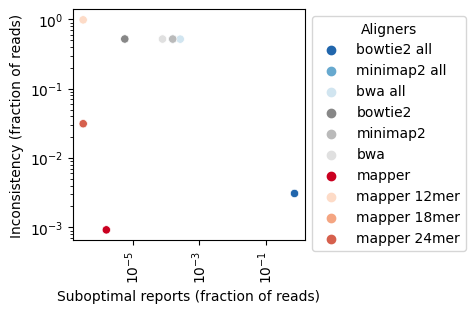

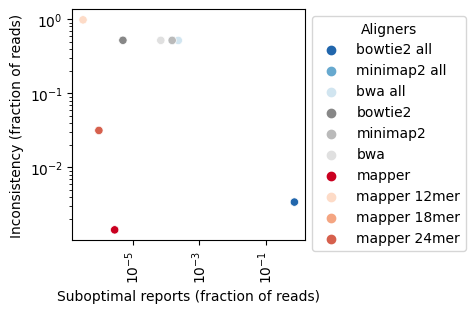

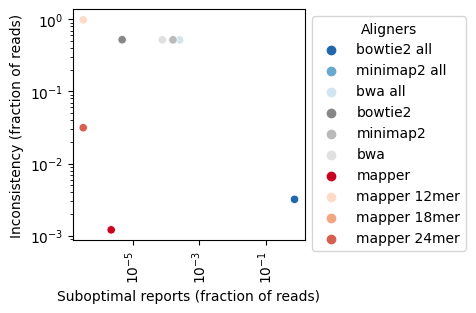

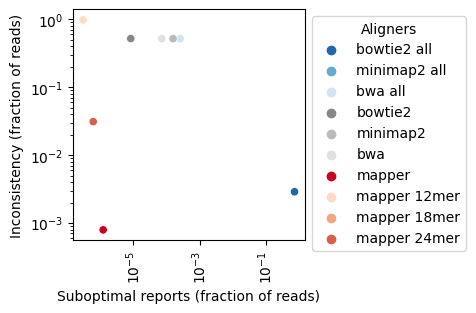

In [4]:
#plot
palette_set = {
    'bowtie2':'#878787','minimap2':'#bababa','bwa':'#e0e0e0',
    'mapper':'#ca0020',
        'bowtie2 all':'#2166ac','minimap2 all':'#67a9cf','bwa all':'#d1e5f0',
    'strobealign':'#000000',
    'last':'#252525',
    'strobealign all':'#053061',
     'mapper no gapped-xmer':'#f4a582',
    'mapper 16mer':'#c2a5cf',
        'mapper 24mer':'#762a83',
         'mapper 20mer':'#9970ab',
        'No gapped k-mer unmatched':'#e66101',
    }


legend_order = [  'strobealign all','bowtie2 all','minimap2 all','bwa all','strobealign','last','bowtie2','minimap2',
                'bwa', 
                'mapper','mapper no gapped-xmer','mapper 16mer','mapper 20mer','mapper 24mer',]

#plot
allresultset=allresultset[allresultset['tool'].isin(legend_order)]
allpenalty = ['bowtie','bwa','minimap','mapper']
for penalty in allpenalty:
    print(penalty)
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3,3))
    sns.scatterplot(data = allresultset[allresultset['penalty']==penalty],
               x='alignment_allworse_all_suboptimal_reads',y='alignment_allworse_single_miss_reads',hue='tool',
                palette=palette_set,hue_order = legend_order)
    axs.set_xlabel('Aligners') 
    axs.set_ylabel('Inconsistency (fraction of reads)')
    axs.set_xlabel('Suboptimal reports (fraction of reads)')
    axs.set(yscale="log")
    axs.set(xscale="log")
    plt.sca(axs)
    plt.legend(title = 'Aligners', bbox_to_anchor=(1.0, 1.0))   
    plt.xticks(rotation=90)
    plt.savefig('SNP_model_multi/comparesum2_%s.pdf'%(penalty.replace('mapper1','mapper').replace('bowtie','bowtie2').replace('minimap','minimap2')),
           bbox_inches='tight')


In [36]:
# end

In [5]:
allsam = glob.glob('SNP_model_multi/bowtie/all_1.fastq_Bactor.*sam')
for samfile in allsam:
    print(samfile)
    sam = pd.read_csv(samfile, 
                             sep='\t',usecols=[0, 1, 2,3,4,5],header=0, 
                             names=['readID', 'Direction','CHR', 'POS','Tag','Score'],comment='@')
    sam['ref']=['_'.join(x.split('_')[:2]).replace('am_BaFr','A1') for x in sam['CHR']]
    sam = sam.sort_values('ref')
    sam['Direction'] = [str(x&16>0) for x in sam['Direction']]
    sam['readIDnew'] = sam['readID']+ ':D' +sam['Direction']
    samsum = pd.DataFrame(sam.groupby(['readIDnew','ref'])['readIDnew'].count())
    samsum.columns = ['count']
    samsum.reset_index(inplace=True)

    samsum_grouped = samsum.groupby('readIDnew')['ref'].apply(lambda x: ','.join(sorted(x))).reset_index()
    ref_combinations_count = samsum_grouped['ref'].value_counts().reset_index(name='count')
    ref_combinations_count.columns = ['ref_combination', 'count']
    ref_combinations_count.to_csv(samfile + '.count',sep='\t',index = False)
    

SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer18.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.bowtie.all.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer24.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.bowtie.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.bwa.all.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer12.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.minimap.all.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.bwa.sam
SNP_model_multi/bowtie/all_1.fastq_Bactor.minimap.sam


In [3]:
# plot
allcount = glob.glob('/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.*sam.count')
ref_combinations_count = pd.DataFrame()
for countfile in allcount:
    print(countfile)
    tool = os.path.basename(countfile).split('.sam')[0].split('all_1.fastq_Bactor.')[1]
    countsum = pd.read_csv(countfile, 
                             sep='\t')
    countsum.columns = ['reference',tool]
    if ref_combinations_count.shape[0] == 0:
        ref_combinations_count = countsum
    else:
        ref_combinations_count = ref_combinations_count.merge(countsum,
                                                              left_on = 'reference',right_on = 'reference',how  = 'outer')

# ref_combinations_count.to_csv('/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.countsum',sep='\t',index = False)
ref_combinations_count['reference'] = [x.replace('am_BaFr','A1') for x in ref_combinations_count['reference']]
ref_combinations_count = ref_combinations_count.sort_values('reference')
ref_combinations_count.index = ref_combinations_count['reference']
ref_combinations_count=ref_combinations_count.iloc[:,1:]
ref_combinations_count = ref_combinations_count.loc[:,['bowtie','bowtie.all',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all','strobealign.all','strobealign','last',
                                                       'mapper1','mapper1.kmer12','mapper1.kmer18','mapper1.kmer25'
                                                      ]]
ref_combinations_count[ref_combinations_count.isna()]=0
ref_combinations_count = ref_combinations_count.sort_index()
ref_combinations_count


/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.bowtie.all.sam.count
/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.bowtie.sam.count
/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.bwa.all.sam.count
/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.bwa.sam.count
/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer12.sam.count
/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer18.sam.count
/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer24.sam.count
/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.kmer25.sam.count
/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.mapper1.sam.count
/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/all_1.fastq_Bactor.minimap.all.sam.count
/Volumes/Tardis/Mapper/SNP_cur

,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,mapper1,mapper1.kmer12,mapper1.kmer18,mapper1.kmer25
reference,,,,,,,,,,
A1,1526400.0,175183.0,1526705.0,1526960.0,1531830.0,1529800.0,863197.0,26375.0,860622.0,854015.0
"A1,aa_BaCe",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaOv,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaCe,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaOv,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
cx_BaOv,8168.0,0.0,9381.0,8889.0,7765.0,6372.0,28.0,0.0,20.0,287.0
"cx_BaOv,cx_BaVu",1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
cx_BaUn,1467.0,0.0,1418.0,1485.0,1508.0,1504.0,15.0,6.0,54.0,34.0


In [4]:
import copy
ref_combinations_count2 = copy.deepcopy(ref_combinations_count)
ref_combinations_countcolsum = ref_combinations_count.sum(axis=0)
for i in ref_combinations_count2.columns:
    ref_combinations_count2.loc[:,i]=ref_combinations_count2.loc[:,i]/sum(ref_combinations_count2.loc[:,i])*100
ref_combinations_count2

,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,mapper1,mapper1.kmer12,mapper1.kmer18,mapper1.kmer25
reference,,,,,,,,,,
A1,47.018670,5.334164,46.868146,46.879471,46.968480,46.813869,26.373202,47.089805,27.581979,27.374162
"A1,aa_BaCe",0.000000,0.000000,0.000000,0.000000,0.000000,0.000031,0.000000,0.000000,0.000000,0.000000
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaOv,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.000000,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrMi,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaCe,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.000000,0.000304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"A1,aa_BaCe,aa_BaDo,aa_BaFa,aa_BaFr,aa_BaOv,aa_BaVu,aa_BaXy,af_BaCe,af_BaDo,af_BaFr,af_BaSt,af_BaTh,af_BaUn,af_BaVu,af_BaXy,am_AkMu,am_AlOn,am_BA,am_BL,am_BaOv,am_BaSa,am_BaSt,am_BaVu,am_BaXy,am_BiPs,am_BlOb,am_BlSp,am_CoAe,am_EnCl,am_EnDu,am_EnMu,am_EsCo,am_FaCy,am_FiSp,am_FlPl,am_HoMa,am_LaSp,am_PaDi,am_PaEx,am_PaMe,am_PhFa,am_PrNa,am_RuLa,am_RuTo,am_StSa,am_TuSa,an_BaOv,an_BaXy,ao_BaFr,ao_BaOv,ao_BaUn,ao_BaXy,av_BaFr,av_BaOv,av_BaTh,av_BaUn,av_BaVu,bf_BaFa,bf_BaUn,bf_BaVu,bj_BaCa,bj_BaUn,bj_BaVu,bj_BaXy,bk_BaCe,bk_BaOv,bk_BaSa,bk_BaTh,bk_BaUn,bq_BaCa,bq_BaDo,bq_BaFi,bq_BaFr,bq_BaOv,bq_BaSa,bq_BaTh,bq_BaUn,bq_BaVu,bq_BaXy,cx_BaCa,cx_BaFa,cx_BaOv,cx_BaUn,cx_BaVu",0.000000,0.000122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
cx_BaOv,0.251604,0.000000,0.287986,0.272903,0.238088,0.194991,0.000855,0.000000,0.000641,0.009199
"cx_BaOv,cx_BaVu",0.000031,0.000000,0.000000,0.000000,0.000031,0.000000,0.000000,0.000000,0.000000,0.000000
cx_BaUn,0.045189,0.000000,0.043531,0.045591,0.046238,0.046024,0.000458,0.010712,0.001731,0.001090


In [101]:
ref_combinations_count2_A1 = ref_combinations_count2.loc[ref_combinations_count2.index.str.contains("A1"),:]
ref_combinations_count2_noA1 = ref_combinations_count2.loc[~ref_combinations_count2.index.str.contains("A1"),:]
ref_combinations_count2_A1.sum(axis = 0).sort_values()


minimap           46.971846
minimap.all       46.983210
bwa               47.038910
bwa.all           47.103082
bowtie            47.119675
mapper1.kmer12    96.331012
mapper1           97.456315
bowtie.all        97.642601
mapper1.kmer25    99.043107
mapper1.kmer18    99.169645
dtype: float64

In [102]:
ref_combinations_count2_noA1.sum(axis = 0).sort_values()


mapper1.kmer18     0.830355
mapper1.kmer25     0.956893
bowtie.all         2.357399
mapper1            2.543685
mapper1.kmer12     3.668988
bowtie            52.880325
bwa.all           52.896918
bwa               52.961090
minimap.all       53.016790
minimap           53.028154
dtype: float64

In [103]:
ref_combinations_count2_A1 = ref_combinations_count2.loc[ref_combinations_count2.index.str.contains("A1"),:]
ref_combinations_count2_noA1 = ref_combinations_count2.loc[~ref_combinations_count2.index.str.contains("A1"),:]
ref_combinations_count2_A1.sum(axis = 0).sort_values()
ref_covsumall = pd.read_csv('mapper/multi/cov_sum.txt',sep='\t')
ref_covsumall.loc[ref_covsumall['Cov']>=1,'Cov']=1
ref_cov = pd.DataFrame(
index = ref_covsumall['Genome'].unique(),
    columns = ref_covsumall['tool'].unique(),
)
for i in ref_covsumall.index:
    ref_cov.loc[ref_covsumall.loc[i,'Genome'],
                ref_covsumall.loc[i,'tool']
               ] = float(ref_covsumall.loc[i,'Cov'])
ref_cov.replace('NaN',0,inplace=True)
ref_cov[ref_cov<0.01]=0
ref_cov = pd.DataFrame(ref_cov)
ref_cov.columns = [x.replace('kmer24','kmer25') for x in ref_cov.columns]
# cov cutoff 0.01
for tool in ref_combinations_count2_A1.columns:
    if tool != 'ref':
        for reference in ref_combinations_count2_A1.index:
            referenceset = reference.split(',')
            i = 0
            for genome in referenceset:
                if genome == 'A1' or ref_cov.loc[genome,tool] > 0:
                    i+=1
            ref_combinations_count2_A1.loc[reference,tool] = ref_combinations_count2_A1.loc[reference,tool]/i
ref_combinations_count2_A1.sum(axis = 0).sort_values()



bowtie.all        22.790699
mapper1           46.859508
bwa.all           46.881912
minimap           46.922610
minimap.all       46.933909
bwa               47.006296
bowtie            47.071298
mapper1.kmer25    48.784214
mapper1.kmer18    49.014076
mapper1.kmer12    65.026483
dtype: float64

In [104]:
ref_combinations_count2_A1 = ref_combinations_count2.loc[ref_combinations_count2.index.str.contains("A1"),:]
ref_combinations_count2_noA1 = ref_combinations_count2.loc[~ref_combinations_count2.index.str.contains("A1"),:]
ref_combinations_count2_A1.sum(axis = 0).sort_values()
ref_covsumall = pd.read_csv('mapper/multi/cov_sum.txt',sep='\t')
ref_covsumall.loc[ref_covsumall['Cov']>=1,'Cov']=1
ref_cov = pd.DataFrame(
index = ref_covsumall['Genome'].unique(),
    columns = ref_covsumall['tool'].unique(),
)
for i in ref_covsumall.index:
    ref_cov.loc[ref_covsumall.loc[i,'Genome'],
                ref_covsumall.loc[i,'tool']
               ] = float(ref_covsumall.loc[i,'Cov'])
ref_cov.replace('NaN',0,inplace=True)
ref_cov[ref_cov<0.05]=0
ref_cov = pd.DataFrame(ref_cov)
ref_cov.columns = [x.replace('kmer24','kmer25') for x in ref_cov.columns]
# cov cutoff 0.05
for tool in ref_combinations_count2_A1.columns:
    if tool != 'ref':
        for reference in ref_combinations_count2_A1.index:
            referenceset = reference.split(',')
            i = 0
            for genome in referenceset:
                if genome == 'A1' or ref_cov.loc[genome,tool] > 0:
                    i+=1
            ref_combinations_count2_A1.loc[reference,tool] = ref_combinations_count2_A1.loc[reference,tool]/i
ref_combinations_count2_A1.sum(axis = 0).sort_values()



bowtie.all        24.606161
bwa.all           46.894318
minimap           46.923961
minimap.all       46.935352
bwa               47.007602
bowtie            47.072653
mapper1           49.890629
mapper1.kmer18    50.718819
mapper1.kmer25    50.880530
mapper1.kmer12    65.026483
dtype: float64

In [106]:
ref_covsumall = pd.read_csv('mapper/multi/cov_sum.txt',sep='\t')
ref_covsumall.loc[ref_covsumall['Cov']>=1,'Cov']=1
ref_cov = pd.DataFrame(
index = ref_covsumall['Genome'].unique(),
    columns = ref_covsumall['tool'].unique(),
)
for i in ref_covsumall.index:
    ref_cov.loc[ref_covsumall.loc[i,'Genome'],
                ref_covsumall.loc[i,'tool']
               ] = float(ref_covsumall.loc[i,'Cov'])
ref_cov.replace('NaN',0,inplace=True)
ref_cov[ref_cov<0.05]=0
ref_cov = pd.DataFrame(ref_cov)
ref_cov.columns = [x.replace('kmer24','kmer25') for x in ref_cov.columns]

ref_cov.index = [x.replace('am_BaFr','A1') for x in ref_cov.index]
ref_abu = copy.deepcopy(ref_cov)
# cov cutoff 0.05
for tool in ref_abu.columns:
        ref_abu[tool]=0
        for reference in ref_combinations_count2.index:
            referenceset = reference.split(',')
            i = 0
            for genome in referenceset:
                if genome == 'A1' or ref_cov.loc[genome,tool] > 0:
                    i+=1
            if i > 0:
                for genome in referenceset:
                    ref_abu.loc[genome,tool] += ref_combinations_count2.loc[reference,tool]/i
ref_abu[ref_abu.isna()]=0
ref_abu.to_csv('mapper/multi/abu_0.05.txt',sep='\t')
ref_abu.head()



,bowtie.all,bowtie,bwa.all,bwa,mapper1.kmer12,mapper1.kmer18,mapper1.kmer25,mapper1,minimap.all,minimap
ao_BaFr,15.769785,11.440855,11.485083,11.487002,9.935904,11.839253,11.796919,11.664345,11.401118,11.398748
A1,24.606161,47.072653,46.894318,47.007602,65.026483,50.718819,50.880530,49.890629,46.935352,46.923961
bq_BaFr,13.004942,7.661819,7.608416,7.605785,4.907159,7.949556,7.861818,7.607761,7.659678,7.658646
av_BaFr,14.072444,10.491256,10.383380,10.384084,7.749092,10.874010,10.741866,10.400815,10.495111,10.494819
af_BaFr,13.063053,7.414158,7.498776,7.490674,4.652205,7.732762,7.655116,7.420946,7.492392,7.491664


In [107]:
ref_abu = pd.read_csv('mapper/multi/abu_0.05.txt',sep='\t')
ref_abu.index = ref_abu['Unnamed: 0']
ref_abu = ref_abu.loc[:,['bowtie','bowtie.all','strobealign.all','strobealign','last',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all',
                                                       'mapper1',
                                                      ]]
ref_abu.head()

,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,mapper1
Unnamed: 0,,,,,,,
ao_BaFr,11.440855,15.769785,11.398748,11.401118,11.487002,11.485083,11.664345
A1,47.072653,24.606161,46.923961,46.935352,47.007602,46.894318,49.890629
bq_BaFr,7.661819,13.004942,7.658646,7.659678,7.605785,7.608416,7.607761
av_BaFr,10.491256,14.072444,10.494819,10.495111,10.384084,10.383380,10.400815
af_BaFr,7.414158,13.063053,7.491664,7.492392,7.490674,7.498776,7.420946


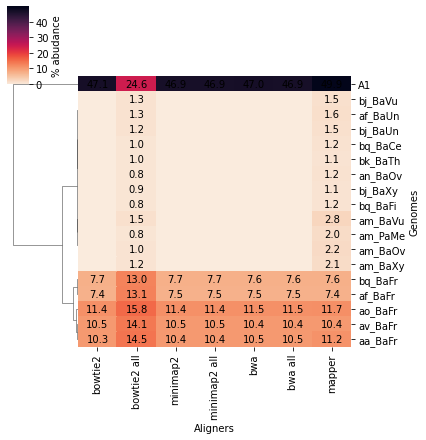

In [115]:
ref_combinations_count3 = ref_abu.loc[:,['bowtie','bowtie.all','strobealign.all','strobealign','last',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all',
                                                       'mapper1',
                                                      ]]
ref_combinations_count3.columns = [x.replace('mapper1','mapper').replace('bowtie','bowtie2').replace('minimap','minimap2').replace('.all',' all') for x in ref_combinations_count3.columns]
ref_combinations_count3 = ref_combinations_count3.loc[ref_combinations_count3.sum(axis = 1)>=2,:]

if True:
    # Create a clustermap with column clustering only
    g = sns.clustermap(data=ref_combinations_count3, 
                       cmap=sns.color_palette("rocket_r", as_cmap=True), 
                       col_cluster=False, #center=0.3, 
                       row_cluster=True,
                       figsize=(6,6), 
                       yticklabels=True,
                       cbar_kws={'ticks': np.linspace(0, 
                                                      50, num=6), 'label': '% abudance'}  # Add more ticks and a label

                      )
    for (i, j), val in np.ndenumerate(g.data2d):
        if val >= 0.1:
            g.ax_heatmap.text(j + 0.5, i + 0.5, f'{val:.1f}', 
                              ha='center', va='center', color='black')

    # Adjust the labels and ticks
    g.ax_heatmap.set_xlabel('Aligners')
    g.ax_heatmap.set_ylabel('Genomes')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
#     g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)  # Ensure y-tick labels are horizontal

    # Save the figure
    plt.savefig('mapper/multi/all_1.fastq_Bactor.cov0.05.pdf')


In [76]:
ref_combinations_count3 = ref_combinations_count2.loc[ref_combinations_count2.sum(axis = 1)>=5,:]
ref_combinations_count4 = ref_combinations_count2.loc[ref_combinations_count2.sum(axis = 1)<5,:]
ref_combinations_count3 = ref_combinations_count3.T
ref_combinations_count3['Others with A1'] = 0
ref_combinations_count3['Others without A1'] = 0
ref_combinations_count3 = ref_combinations_count3.T
for tool in ref_combinations_count4.columns:
    ref_combinations_count4sub = ref_combinations_count4.loc[ref_combinations_count4.index.str.contains("A1"),tool]
    ref_combinations_count3.loc['Others with A1',tool] = sum(ref_combinations_count4sub)
    ref_combinations_count4sub = ref_combinations_count4.loc[~ref_combinations_count4.index.str.contains("A1"),tool]
    ref_combinations_count3.loc['Others without A1',tool] = sum(ref_combinations_count4sub)
ref_combinations_count3 = ref_combinations_count3.sort_index()
ref_combinations_count3.tail()


,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,mapper1,mapper1.kmer12,mapper1.kmer18,mapper1.kmer25
reference,,,,,,,,,,
aa_BaFr,10.313704,0.017600,10.345157,10.348262,10.434629,10.397251,0.074732,0.655240,0.082173,0.088436
af_BaFr,7.389484,0.015712,7.467228,7.467877,7.474612,7.449703,0.052643,0.644528,0.062399,0.069364
ao_BaFr,11.409390,0.011966,11.368965,11.371747,11.466793,11.425301,0.105591,0.535619,0.113421,0.123759
av_BaFr,10.461870,0.020157,10.465312,10.465817,10.366254,10.330234,0.099389,0.578468,0.106819,0.102988
bq_BaFr,7.642105,0.013976,7.636379,7.637532,7.591924,7.561642,0.069630,0.508838,0.074546,0.080615


In [77]:
ref_combinations_count2.sum(axis = 0)

bowtie            100.0
bowtie.all        100.0
minimap           100.0
minimap.all       100.0
bwa               100.0
bwa.all           100.0
mapper1           100.0
mapper1.kmer12    100.0
mapper1.kmer18    100.0
mapper1.kmer25    100.0
dtype: float64

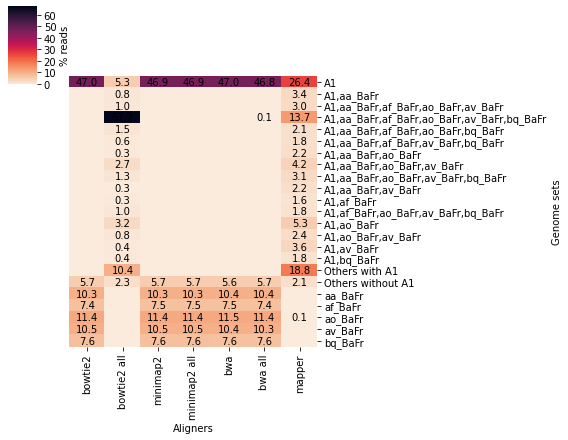

In [78]:
ref_combinations_count3 = ref_combinations_count3.loc[:,['bowtie','bowtie.all',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all','strobealign.all','strobealign','last',
                                                       'mapper1',
                                                      ]]
ref_combinations_count3.columns = [x.replace('mapper1','mapper').replace('bowtie','bowtie2').replace('minimap','minimap2').replace('.all',' all') for x in ref_combinations_count3.columns]

if True:
    # Create a clustermap with column clustering only
    g = sns.clustermap(data=ref_combinations_count3, 
                       cmap=sns.color_palette("rocket_r", as_cmap=True), 
                       col_cluster=False, #center=0.3, 
                       row_cluster=False,
                       figsize=(8,6), yticklabels=True,
                       cbar_kws={'ticks': np.linspace(0, 
                                                      70, num=8), 'label': '% reads'}  # Add more ticks and a label

                      )
    for (i, j), val in np.ndenumerate(g.data2d):
        if val > 0.1:
            g.ax_heatmap.text(j + 0.5, i + 0.5, f'{val:.1f}', 
                              ha='center', va='center', color='black')

    # Adjust the labels and ticks
    g.ax_heatmap.set_xlabel('Aligners')
    g.ax_heatmap.set_ylabel('Genome sets')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
#     g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)  # Ensure y-tick labels are horizontal

    # Save the figure
    plt.savefig('mapper/multi//all_1.fastq_Bactor.countsum.pdf')


In [36]:
ref_combinations_count3 = ref_combinations_count.loc[ref_combinations_count2.sum(axis = 1)>=5,:]
ref_combinations_count4 = ref_combinations_count.loc[ref_combinations_count2.sum(axis = 1)<5,:]
ref_combinations_count3 = ref_combinations_count3.T
ref_combinations_count3['Others with A1'] = 0
ref_combinations_count3['Others without A1'] = 0
ref_combinations_count3 = ref_combinations_count3.T
for tool in ref_combinations_count4.columns:
    ref_combinations_count4sub = ref_combinations_count4.loc[ref_combinations_count4.index.str.contains("A1"),tool]
    ref_combinations_count3.loc['Others with A1',tool] = sum(ref_combinations_count4sub)
    ref_combinations_count4sub = ref_combinations_count4.loc[~ref_combinations_count4.index.str.contains("A1"),tool]
    ref_combinations_count3.loc['Others without A1',tool] = sum(ref_combinations_count4sub)
ref_combinations_count3 = ref_combinations_count3.sort_index()
ref_combinations_count3.tail()


,bowtie,bowtie.all,minimap,minimap.all,bwa,bwa.all,mapper1,mapper1.kmer12,mapper1.kmer18,mapper1.kmer25
reference,,,,,,,,,,
aa_BaFr,334821.0,578.0,336988.0,337064.0,340315.0,339765.0,2446.0,367.0,2564.0,2759.0
af_BaFr,239890.0,516.0,243241.0,243244.0,243777.0,243444.0,1723.0,361.0,1947.0,2164.0
ao_BaFr,370391.0,393.0,370338.0,370401.0,373978.0,373360.0,3456.0,300.0,3539.0,3861.0
av_BaFr,339631.0,662.0,340902.0,340893.0,338085.0,337575.0,3253.0,324.0,3333.0,3213.0
bq_BaFr,248091.0,459.0,248751.0,248770.0,247603.0,247102.0,2279.0,285.0,2326.0,2515.0


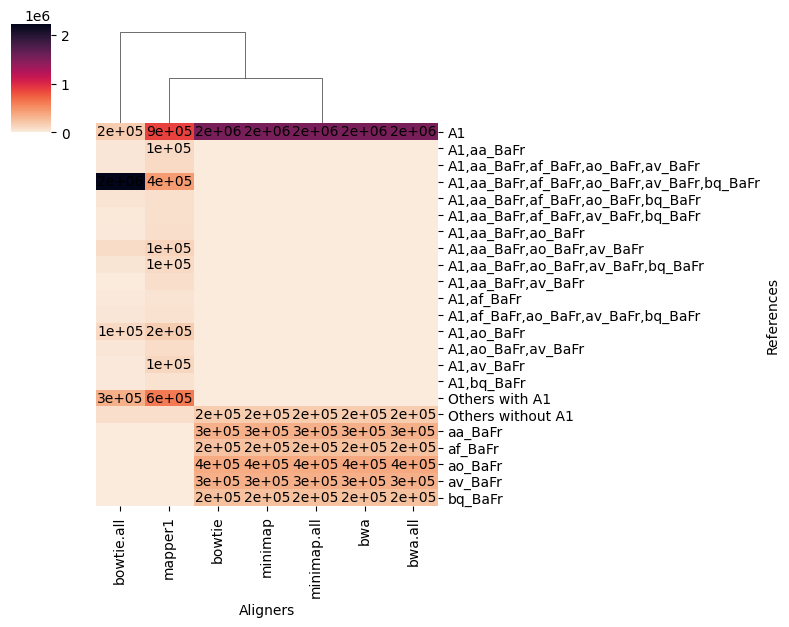

In [35]:
ref_combinations_count3 = ref_combinations_count3.loc[:,['bowtie','bowtie.all',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all','strobealign.all','strobealign','last',
                                                       'mapper1',
                                                      ]]
if True:
    # Create a clustermap with column clustering only
    g = sns.clustermap(data=ref_combinations_count3, 
                       cmap=sns.color_palette("rocket_r", as_cmap=True), 
                       col_cluster=True, #center=0.3, 
                       row_cluster=False,
                       figsize=(8,6), yticklabels=True,
#                        cbar_kws={'ticks': np.linspace(0, 
#                                                       70, num=8), 'label': '% reads'}  # Add more ticks and a label

                      )
    for (i, j), val in np.ndenumerate(g.data2d):
        if val > 100000:
            g.ax_heatmap.text(j + 0.5, i + 0.5, f'{val:.0e}', 
                              ha='center', va='center', color='black')

    # Adjust the labels and ticks
    g.ax_heatmap.set_xlabel('Aligners')
    g.ax_heatmap.set_ylabel('References')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
#     g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)  # Ensure y-tick labels are horizontal

    # Save the figure
    plt.savefig('SNP_model_multi/all_1.fastq_Bactor.countsumall2.pdf')


In [2]:
# check sam ref coverage
folder = '/Volumes/Tardis/Mapper/SNP_curate/SNP_model_multi/bowtie/'
# load ref
from Bio import SeqIO
ref_len = {}
for record in SeqIO.parse('/Volumes/Tardis/Mapper/SNP_curate/test_data/multi_Genome/Bactor/all_final.scaffolds.fasta','fasta'):
    species = str(record.id).split('_sca')[0].split('_NODE')[0]
    ref_len.setdefault(species,0)
    ref_len[species] += len(str(record.seq))
ref_len


{'aa_BaCe': 3833540,
 'aa_BaDo': 5681194,
 'aa_BaFa': 6268938,
 'aa_BaFr': 5349002,
 'aa_BaOv': 6633912,
 'aa_BaVu': 5199152,
 'aa_BaXy': 6432453,
 'af_BaCe': 5314253,
 'af_BaDo': 5843668,
 'af_BaFr': 5275351,
 'af_BaSt': 4193667,
 'af_BaTh': 6701940,
 'af_BaUn': 4970798,
 'af_BaVu': 5507646,
 'af_BaXy': 6406153,
 'am_AkMu': 2876208,
 'am_AlOn': 3537260,
 'am_BaFr': 5204643,
 'am_BA': 2079252,
 'am_BaOv': 6742449,
 'am_BaSa': 5831116,
 'am_BaSt': 3640259,
 'am_BaVu': 5319488,
 'am_BaXy': 6663961,
 'am_BiPs': 2227668,
 'am_BL': 2403024,
 'am_BlOb': 3393963,
 'am_BlSp': 3524598,
 'am_CoAe': 2215905,
 'am_EnCl': 5264149,
 'am_EnDu': 3088964,
 'am_EnMu': 3384881,
 'am_EsCo': 5995805,
 'am_FaCy': 3278931,
 'am_FiSp': 1835172,
 'am_FlPl': 4595415,
 'am_HoMa': 4123339,
 'am_LaSp': 4923238,
 'am_PaDi': 5204877,
 'am_PaEx': 3241286,
 'am_PaMe': 4946021,
 'am_PhFa': 2443602,
 'am_PrMi': 3970443,
 'am_PrNa': 3004562,
 'am_RuLa': 4524086,
 'am_RuTo': 2950825,
 'am_StSa': 2378423,
 'am_TuSa': 42841

In [49]:
import datetime
ref_covsumall = pd.DataFrame()
read_len = 150
def is_read_reverse_strand(flag):
    return bool(flag & 16)

for samfile in glob.glob('%s/all*sam'%(folder)):
    print(datetime.datetime.now(), 'process ',samfile)
    tool = os.path.basename(samfile).split('Bactor.')[1].split('.sam')[0]
    sam1 = ''
    sam1 = pd.read_csv(samfile,sep='\t')
    print(datetime.datetime.now(), 'done reading ',samfile)
    ref_cov = {}
    allCHRPOS = set()
    for i in sam1.index:
        direction = is_read_reverse_strand(sam1.loc[i,'Direction'])
        CHR = sam1.loc[i,'CHR']
        POS = sam1.loc[i,'POS']
        CHRPOS = '%s\t%s'%(CHR,POS)
        if i%1000000 == 0:
            print(datetime.datetime.now(), 'process %s lines'%(i))
        if CHRPOS not in allCHRPOS:
            species = CHR.split('_sca')[0].split('_NODE')[0]
            ref_cov_species = ref_cov.get(species,{})
            ref_cov_species.setdefault(CHR,set())
            ref_cov_species[CHR].add(POS)
            if direction:
                for POS2 in range(max(POS-read_len,0),POS):
                    ref_cov_species[CHR].add(POS2)
            else:
                for POS2 in range(POS,POS+read_len):
                    ref_cov_species[CHR].add(POS2)
            ref_cov[species] =  ref_cov_species  
            allCHRPOS.add(CHRPOS)
    ref_cov2 = {}
    for species in ref_cov:
        ref_cov2.setdefault(species,0)
        for CHR in ref_cov[species]:
            ref_cov2[species] += len(ref_cov[species][CHR])
    for species in ref_cov:
        ref_cov2[species]=ref_cov2[species]/ref_len[species]
    ref_covsum = pd.DataFrame(ref_cov2,index = range(0,1))
    ref_covsum = ref_covsum.T
    ref_covsum['tool'] = tool
    ref_covsumall = ref_covsumall.append(ref_covsum)
    ref_covsumall.to_csv('mapper/multi/cov_sum.txt',sep='\t',mode = 'a')
    

In [3]:
ref_covsumall = pd.read_csv('mapper/multi/cov_sum.txt',sep='\t')
ref_covsumall.loc[ref_covsumall['Cov']>=1,'Cov']=1
ref_cov = pd.DataFrame(
index = ref_covsumall['Genome'].unique(),
    columns = ref_covsumall['tool'].unique(),
)
for i in ref_covsumall.index:
    ref_cov.loc[ref_covsumall.loc[i,'Genome'],
                ref_covsumall.loc[i,'tool']
               ] = float(ref_covsumall.loc[i,'Cov'])
ref_cov.replace('NaN',0,inplace=True)
ref_cov[ref_cov.isna()]=0
ref_cov = pd.DataFrame(ref_cov)
ref_combinations_count3 = ref_cov.loc[ref_cov.sum(axis = 1)>=0.1,:]
ref_combinations_count3 = ref_combinations_count3*100
ref_combinations_count3


,bowtie.all,bowtie,bwa.all,bwa,mapper1.kmer12,mapper1.kmer18,mapper1.kmer24,mapper1,minimap.all,minimap
ao_BaFr,85.755400,76.551000,78.300886,76.576042,12.036207,82.650936,82.627795,82.756842,76.819010,76.822980
am_BaFr,100.000000,99.986666,99.998617,99.976252,28.841114,99.762846,99.772434,100.000000,99.983111,99.984130
bq_BaFr,84.451546,71.290113,73.862430,71.435142,8.911382,80.329143,80.307638,80.433765,71.597171,71.595088
av_BaFr,85.409071,76.291016,78.029875,76.248456,11.465656,82.918366,82.891094,82.947241,76.740369,76.740193
af_BaFr,80.138762,67.268889,69.938057,67.530274,8.210923,75.969789,75.963761,76.098026,67.969828,67.972975
aa_BaFr,81.574413,72.504908,74.649851,72.930334,10.594032,78.691520,78.687781,78.816385,73.054824,73.056937
bj_BaVu,4.250905,1.332540,1.644604,1.354994,0.000000,1.355264,1.365777,2.299483,1.290177,1.291084
am_BaOv,4.938339,1.948239,2.125504,1.980111,0.103271,1.693910,1.697202,2.434605,1.945243,1.941164
af_BaUn,5.152694,1.698721,2.046854,1.722239,0.025489,1.803393,1.791040,2.719583,1.716948,1.741390
af_BaSt,6.362093,0.981909,1.315126,0.955369,0.028638,0.822288,0.819593,1.894953,0.966624,0.965718


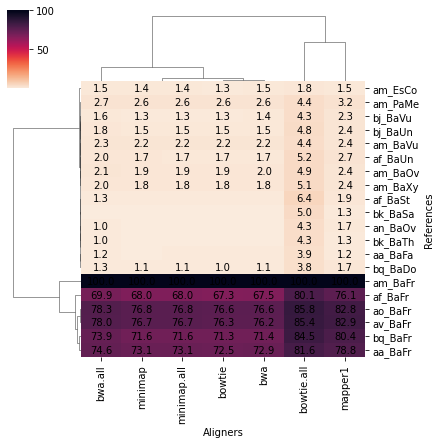

In [5]:
ref_combinations_count3 = ref_combinations_count3.loc[:,['bowtie','bowtie.all',
                                                       'minimap','minimap.all',
                                                       'bwa','bwa.all','strobealign.all','strobealign','last',
                                                       'mapper1',
                                                      ]]
if True:
    # Create a clustermap with column clustering only
    g = sns.clustermap(data=ref_combinations_count3, 
                       cmap=sns.color_palette("rocket_r", as_cmap=True), 
                       col_cluster=True, #center=0.3, 
                       row_cluster=True,
                       figsize=(6,6), 
                       yticklabels=True,
#                        cbar_kws={'ticks': np.linspace(0, 
#                                                       70, num=8), 'label': '% reads'}  # Add more ticks and a label

                      )
    for (i, j), val in np.ndenumerate(g.data2d):
        if val >= 1:
            g.ax_heatmap.text(j + 0.5, i + 0.5, f'{val:.1f}', 
                              ha='center', va='center', color='black')

    # Adjust the labels and ticks
    g.ax_heatmap.set_xlabel('Aligners')
    g.ax_heatmap.set_ylabel('References')
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90)
#     g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)  # Ensure y-tick labels are horizontal

    # Save the figure
    plt.savefig('mapper/multi/all_1.fastq_Bactor.cov.pdf')
